In [50]:
import sys
import os
import warnings

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.stats as st
from scipy.optimize import minimize
import random

%matplotlib inline

# Import data

In [2]:
path_data = os.path.join("data", "processed.csv")

In [3]:
%%time
df = pd.read_csv(path_data, sep=";")
print "# rows: {}".format(len(df))

# rows: 28439141
Wall time: 1min 9s


In [4]:
df.dtypes

BETRIEBSTAG            object
FAHRT_BEZEICHNER       object
BETREIBER_ID           object
VERKEHRSMITTEL_TEXT    object
BPUIC                   int64
ANKUNFTSZEIT           object
AN_PROGNOSE            object
ABFAHRTSZEIT           object
AB_PROGNOSE            object
dtype: object

In [5]:
dateparser_ddmmyyy = '%d.%m.%Y'
dateparser_ddmmyyHHMM = '%d.%m.%Y %H:%M'
dateparser_ddmmyyHHMMSS = '%d.%m.%Y %H:%M:%S'

In [6]:
%%time
df["BETRIEBSTAG"] = pd.to_datetime(df["BETRIEBSTAG"], format=dateparser_ddmmyyy)
df["ANKUNFTSZEIT"] = pd.to_datetime(df["ANKUNFTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AN_PROGNOSE"] = pd.to_datetime(df["AN_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)
df["ABFAHRTSZEIT"] = pd.to_datetime(df["ABFAHRTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AB_PROGNOSE"] = pd.to_datetime(df["AB_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)

Wall time: 10min 23s


In [7]:
df.dtypes

BETRIEBSTAG            datetime64[ns]
FAHRT_BEZEICHNER               object
BETREIBER_ID                   object
VERKEHRSMITTEL_TEXT            object
BPUIC                           int64
ANKUNFTSZEIT           datetime64[ns]
AN_PROGNOSE            datetime64[ns]
ABFAHRTSZEIT           datetime64[ns]
AB_PROGNOSE            datetime64[ns]
dtype: object

In [8]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT


In [9]:
%%time
df["VERSPAETUNG_AN"] = df["AN_PROGNOSE"] - df["ANKUNFTSZEIT"]
df["VERSPAETUNG_AB"] = df["AB_PROGNOSE"] - df["ABFAHRTSZEIT"]

Wall time: 2.11 s


In [10]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT


In [28]:
%%time
df_ic = df[df["VERKEHRSMITTEL_TEXT"] == "IC"]

Wall time: 1.33 s


In [58]:
%%time
df_s = df[df["VERKEHRSMITTEL_TEXT"] == "S"]

Wall time: 5.03 s


# Overal arrival and departure delay

In [11]:
%%time
df_an_versp = df["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null arr-delays: {}".format(len(df_an_versp))

# non-null arr-delays: 24970365
Wall time: 2min 53s


In [12]:
left = -5.0
right = 15.00000001
step = 0.25

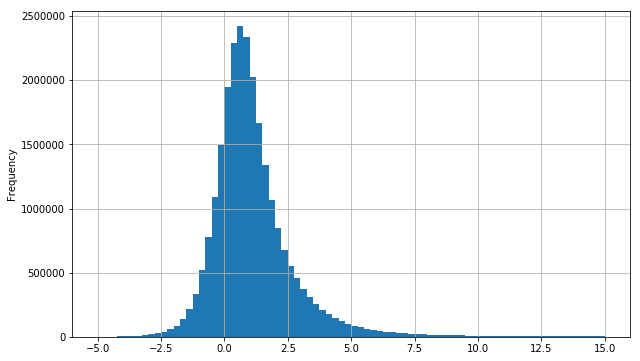

In [13]:
an_range = np.arange(left, right, step)
df_an_versp.plot.hist(bins=an_range, figsize=(10, 6), grid=True)

# non-null arr-delays: 583939
Wall time: 4.68 s


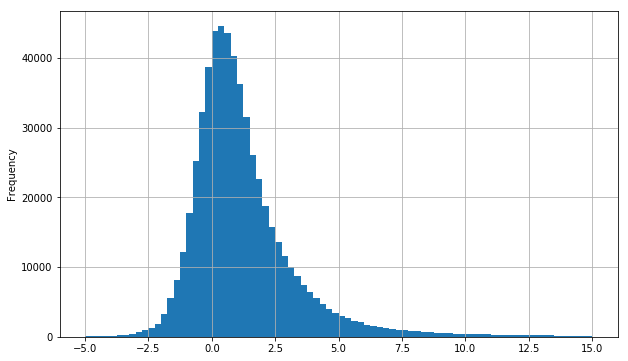

In [30]:
%%time
df_an_versp_ic = df_ic["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null ic-arr-delays: {}".format(len(df_an_versp_ic))
df_an_versp_ic.plot.hist(bins=an_range, figsize=(10, 6), grid=True)

# non-null s-arr-delays: 17678577
Wall time: 2min 13s


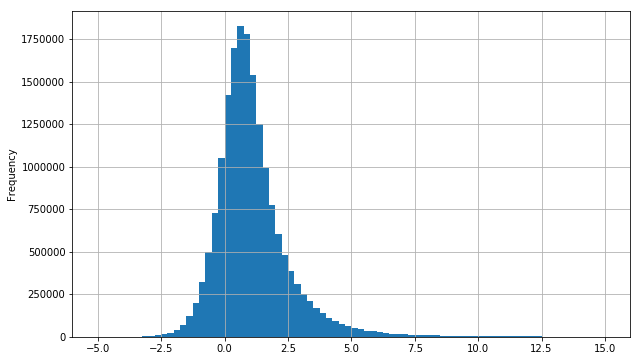

In [59]:
%%time
df_an_versp_s = df_s["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null s-arr-delays: {}".format(len(df_an_versp_s))
df_an_versp_s.plot.hist(bins=an_range, figsize=(10, 6), grid=True)

In [14]:
df_ab_versp = df["VERSPAETUNG_AB"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null dep-delays: {}".format(len(df_ab_versp))

# non-null dep-delays: 25619629


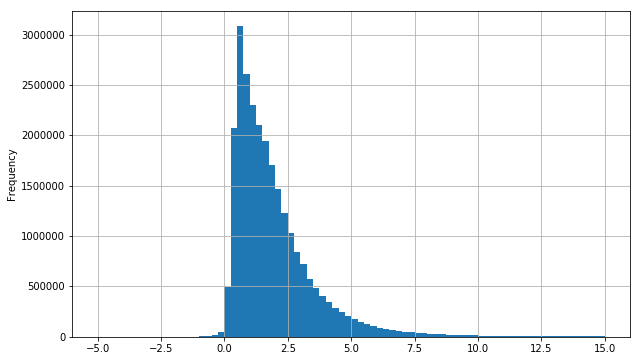

In [15]:
ab_range = np.arange(left, right, step)
df_ab_versp.plot.hist(bins=ab_range, figsize=(10, 6), grid=True)

# Grouping

In [16]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT


In [17]:
%%time
df["TRAIN_ID"] = df["FAHRT_BEZEICHNER"].apply(lambda x: ":".join(x.split(":")[:-1]))

Wall time: 16.9 s


In [18]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB,TRAIN_ID
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT,80:807000:19700
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56,80:807000:19701
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT,80:807000:19702
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35,80:807000:19703
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT,80:807000:19704


In [19]:
%%time
gpd = df.groupby(["TRAIN_ID", "BPUIC"])

Wall time: 3.68 s


In [20]:
%%time
df_tt = df[["TRAIN_ID", "BPUIC", "ANKUNFTSZEIT", "ABFAHRTSZEIT", "BETRIEBSTAG"]].groupby(["TRAIN_ID", "BPUIC"]).agg({"ANKUNFTSZEIT": min, "ABFAHRTSZEIT": min, "BETRIEBSTAG": len}).reset_index().sort_values(by=["TRAIN_ID", "ABFAHRTSZEIT", "ANKUNFTSZEIT"])
df_tt = df_tt.rename(columns={"BETRIEBSTAG": "COUNT"})
df_tt = df_tt[["TRAIN_ID", "BPUIC", "ANKUNFTSZEIT", "ABFAHRTSZEIT", "COUNT"]]

Wall time: 7.53 s


In [21]:
%%time
df_tt.to_csv(os.path.join("data", "train_bp_uic_counts.csv"), sep=";", index=False)

Wall time: 1.7 s


# Optimization

## Distributions

In [141]:
all_distributions = set([x for x in st._continuous_distns.__dict__["__all__"] if not x.endswith("_gen")])
print "# continous distributions: {}".format(len(all_distributions))
excluded_distributions = set([])
print "# excluded distributions: {}".format(len(excluded_distributions))
analysed_distributions = all_distributions - excluded_distributions
print "# analysed distributions: {}".format(len(analysed_distributions))
print analysed_distributions

# continous distributions: 99
# excluded distributions: 0
# analysed distributions: 99
set(['genhalflogistic', 'triang', 'rayleigh', 'betaprime', 'foldnorm', 'dgamma', 'ksone', 'gilbrat', 'expon', 'lognorm', 'vonmises_line', 'anglit', 'truncnorm', 'rice', 'gennorm', 'norm', 'halfgennorm', 'kappa4', 'kappa3', 't', 'norminvgauss', 'fisk', 'levy_stable', 'levy', 'pareto', 'halflogistic', 'semicircular', 'uniform', 'mielke', 'ncx2', 'logistic', 'gengamma', 'johnsonsu', 'moyal', 'powernorm', 'powerlaw', 'burr', 'johnsonsb', 'wrapcauchy', 'argus', 'skewnorm', 'gamma', 'wald', 'arcsine', 'maxwell', 'crystalball', 'gausshyper', 'tukeylambda', 'loglaplace', 'exponweib', 'pearson3', 'chi', 'burr12', 'cosine', 'truncexpon', 'kstwobign', 'recipinvgauss', 'nct', 'foldcauchy', 'levy_l', 'ncf', 'nakagami', 'erlang', 'reciprocal', 'f', 'loggamma', 'invgamma', 'powerlognorm', 'laplace', 'vonmises', 'exponnorm', 'frechet_l', 'genexpon', 'lomax', 'frechet_r', 'dweibull', 'rdist', 'gumbel_r', 'gompertz', 

In [22]:
dist_names_large = [
    'alpha',
    'anglit',
    'arcsine',
    'beta',
    'betaprime',
    'bradford',
    'burr',
    'cauchy',
    'chi',
    'chi2',
    'cosine',
    'dgamma',
    'dweibull',
    'erlang',
    'expon',
    'exponnorm',
    'exponweib',
    'exponpow',
    'f',
    'fatiguelife',
    'fisk',
    'foldcauchy',
    'foldnorm',
    'frechet_r',
    'frechet_l',
    'genlogistic',
    'genpareto',
    'gennorm',
    'genexpon',
    'genextreme',
#     'gausshyper',
    'gamma',
    'gengamma',
    'genhalflogistic',
    'gilbrat',
    'gompertz',
    'gumbel_r',
    'gumbel_l',
    'halfcauchy',
    'halflogistic',
    'halfnorm',
    'halfgennorm',
    'hypsecant',
    'invgamma',
    'invgauss',
    'invweibull',
    'johnsonsb',
    'johnsonsu',
    'ksone',
    'kstwobign',
    'laplace',
    'levy',
    'levy_l',
#     'levy_stable',
    'logistic',
    'loggamma',
    'loglaplace',
    'lognorm',
    'lomax',
    'maxwell',
    'mielke',
    'nakagami',
    'ncx2',
#     'ncf',
    'nct',
    'norm',
    'pareto',
    'pearson3',
    'powerlaw',
    'powerlognorm',
    'powernorm',
#     'rdist',
    'reciprocal',
    'rayleigh',
    'rice',
    'recipinvgauss',
    'semicircular',
    't',
    'triang',
    'truncexpon',
    'truncnorm',
    'tukeylambda',
    'uniform',
    'vonmises',
    'vonmises_line',
    'wald',
    'weibull_min',
    'weibull_max',
    'wrapcauchy',
]

In [23]:
dist_names_small = [
    'norm', 
    'lognorm',
    'weibull_min',
     'weibull_max',
    'alpha',
    'cauchy',
    'powerlognorm',
    'chi',
    'erlang',
    'expon',
    'gamma',
    'gumbel_r',
    'halfcauchy',
    'maxwell',
    'wald',
    'levy',
    'levy_l',
    'pareto',
]


## Definition

In [47]:
def optimize(dist_name, data, opt_type='kst'):
    dist = getattr(scipy.stats, dist_name)
    first_guess_data = data if len(data) < 365 else [random.choice(data) for _ in range(365)]
    first_guess = dist.fit(first_guess_data)
    left = -5.0
    right = 10.0000000000000001
    step = 0.25
    r = np.arange(left, right, step)
    hist_emp = np.histogram(data, r, density=True)[0]
    r_m = np.array([(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)])
    def fun_eval(act_paras, opt_type=opt_type):
        if opt_type == 'kst':
            d, p = scipy.stats.kstest(data, dist_name, act_paras)
            return d
        else:
            hist_exp = dist.pdf(r_m, *act_paras[:-2], loc=act_paras[-2], scale=act_paras[-1])
            if opt_type == 'cst':
                return st.chisquare(hist_emp, f_exp=hist_exp).statistic
            elif opt_type == 'ss':
                return np.power(hist_emp - hist_exp, 2.0).sum()
            elif opt_type == 'as':
                return np.absolute(hist_emp - hist_exp).sum()
            else:
                raise ValueError("{} is not a valid argument".format(opt_type))
    opt_paras = minimize(fun_eval, first_guess, method='nelder-mead')
    return opt_paras

In [131]:
def evaluate(data, dist_names=dist_names_large, left=left, right=right, step=step, plot_best_n=5):
    # plot data
    x = np.arange(left, right, step)
    y = np.array(data)
    plt.figure(figsize=(13,9))
    h = plt.hist(y, bins=x, color='black', density=False)

    # optimization per distribution
    res_per_dist_name = {}
    for dist_name in dist_names:
        print dist_name
        try:
            res = optimize(dist_name, y, opt_type='as')
            res_per_dist_name[dist_name] = res
        except Exception as e:
            print "no success: {}".format(e)

    # plot best distributions
    sorted_dist_name_res_pairs = sorted(res_per_dist_name.items(), key=lambda p: float("inf") if math.isnan(p[1].fun) else p[1].fun) # be aware: sorting not correct if nan's are not set to inf!!!
    x_dist=np.arange(left, right, 0.05)
    for dist_name, res in sorted_dist_name_res_pairs[:plot_best_n]:
            dist = getattr(scipy.stats, dist_name)
            param = res.x
            pdf_fitted = dist.pdf(x_dist, *param[:-2], loc=param[-2], scale=param[-1]) * h[0].sum() * step
            plt.plot(x_dist, pdf_fitted, label="{} {:.4f} {}".format(dist_name, res.fun, res.success))
    plt.xlim(x[0], x[-1])
    plt.legend(loc='upper right')
    plt.show()
    return res_per_dist_name

## Analysis

alpha
anglit
arcsine
beta
betaprime
bradford
burr
cauchy
chi
chi2
cosine
dgamma
dweibull
erlang
expon
exponnorm
exponweib
exponpow
f
fatiguelife
fisk
foldcauchy
foldnorm
frechet_r
frechet_l
genlogistic
genpareto
gennorm
genexpon
genextreme
gamma
gengamma
genhalflogistic
gilbrat
gompertz
gumbel_r
gumbel_l
halfcauchy
halflogistic
halfnorm
halfgennorm
hypsecant
invgamma
invgauss
invweibull
johnsonsb
johnsonsu
ksone
kstwobign
laplace
levy
levy_l
logistic
loggamma
loglaplace
lognorm
lomax
maxwell
mielke
nakagami
ncx2
nct
norm
pareto
pearson3
powerlaw
powerlognorm
powernorm
reciprocal
rayleigh
rice
recipinvgauss
semicircular
t
triang
truncexpon
truncnorm
tukeylambda
uniform
vonmises
vonmises_line
wald
weibull_min
weibull_max
wrapcauchy


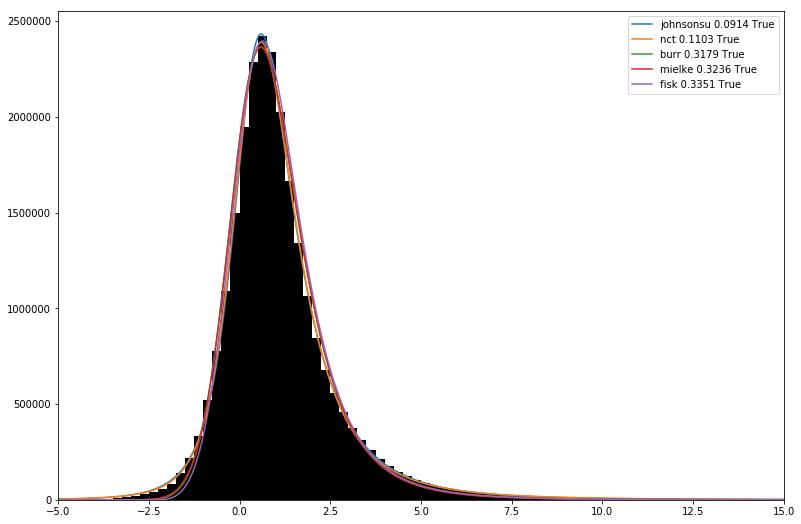

alpha
anglit
arcsine
beta
betaprime
bradford
burr
cauchy
chi
chi2
cosine
dgamma
dweibull
erlang
expon
exponnorm
exponweib
exponpow
f
fatiguelife
fisk
foldcauchy
foldnorm
frechet_r
frechet_l
genlogistic
genpareto
gennorm
genexpon
genextreme
gamma
gengamma
genhalflogistic
gilbrat
gompertz
gumbel_r
gumbel_l
halfcauchy
halflogistic
halfnorm
halfgennorm
hypsecant
invgamma
invgauss
invweibull
johnsonsb
johnsonsu
ksone
kstwobign
laplace
levy
levy_l
logistic
loggamma
loglaplace
lognorm
lomax
maxwell
mielke
nakagami
ncx2
nct
norm
pareto
pearson3
powerlaw
powerlognorm
powernorm
reciprocal
rayleigh
rice
recipinvgauss
semicircular
t
triang
truncexpon
truncnorm
tukeylambda
uniform
vonmises
vonmises_line
wald
weibull_min
weibull_max
wrapcauchy


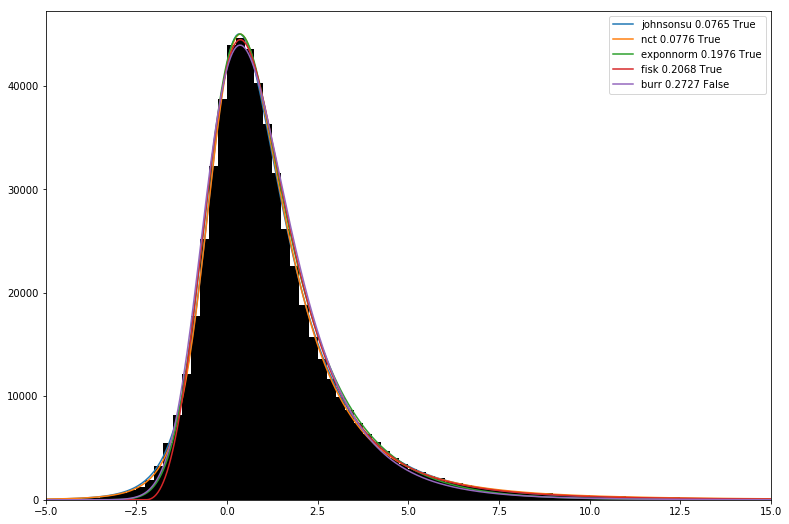

alpha
anglit
arcsine
beta
betaprime
bradford
burr
cauchy
chi
chi2
cosine
dgamma
dweibull
erlang
expon
exponnorm
exponweib
exponpow
f
fatiguelife
fisk
foldcauchy
foldnorm
frechet_r
frechet_l
genlogistic
genpareto
gennorm
genexpon
genextreme
gamma
gengamma
genhalflogistic
gilbrat
gompertz
gumbel_r
gumbel_l
halfcauchy
halflogistic
halfnorm
halfgennorm
hypsecant
invgamma
invgauss
invweibull
johnsonsb
johnsonsu
ksone
kstwobign
laplace
levy
levy_l
logistic
loggamma
loglaplace
lognorm
lomax
maxwell
mielke
nakagami
ncx2
nct
norm
pareto
pearson3
powerlaw
powerlognorm
powernorm
reciprocal
rayleigh
rice
recipinvgauss
semicircular
t
triang
truncexpon
truncnorm
tukeylambda
uniform
vonmises
vonmises_line
wald
weibull_min
weibull_max
wrapcauchy


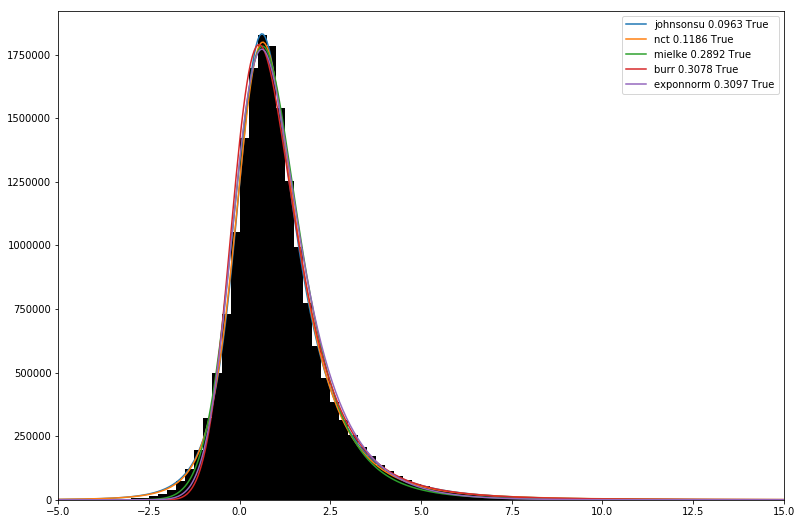

In [132]:
warnings.filterwarnings(action='ignore')
res_per_dist_name_all_an = evaluate(df_an_versp)
res_per_dist_name_ic_an = evaluate(df_an_versp_ic)
res_per_dist_name_s_an = evaluate(df_an_versp_s)

In [137]:
funs = [["{} (all: {}, ic: {}, s: {})".format(dist_name, res_per_dist_name_all_an[dist_name]["success"], res_per_dist_name_ic_an[dist_name]["success"], res_per_dist_name_s_an[dist_name]["success"]), res_per_dist_name_all_an[dist_name]["fun"], res_per_dist_name_ic_an[dist_name]["fun"],  res_per_dist_name_s_an[dist_name]["fun"]] for dist_name in res_per_dist_name_all_an.keys()]
df_funs = pd.DataFrame(funs, columns=["dist_name", "fun_all", "fun_ic", "fun_s"]).set_index("dist_name").sort_values(by=["fun_all"], ascending=False)

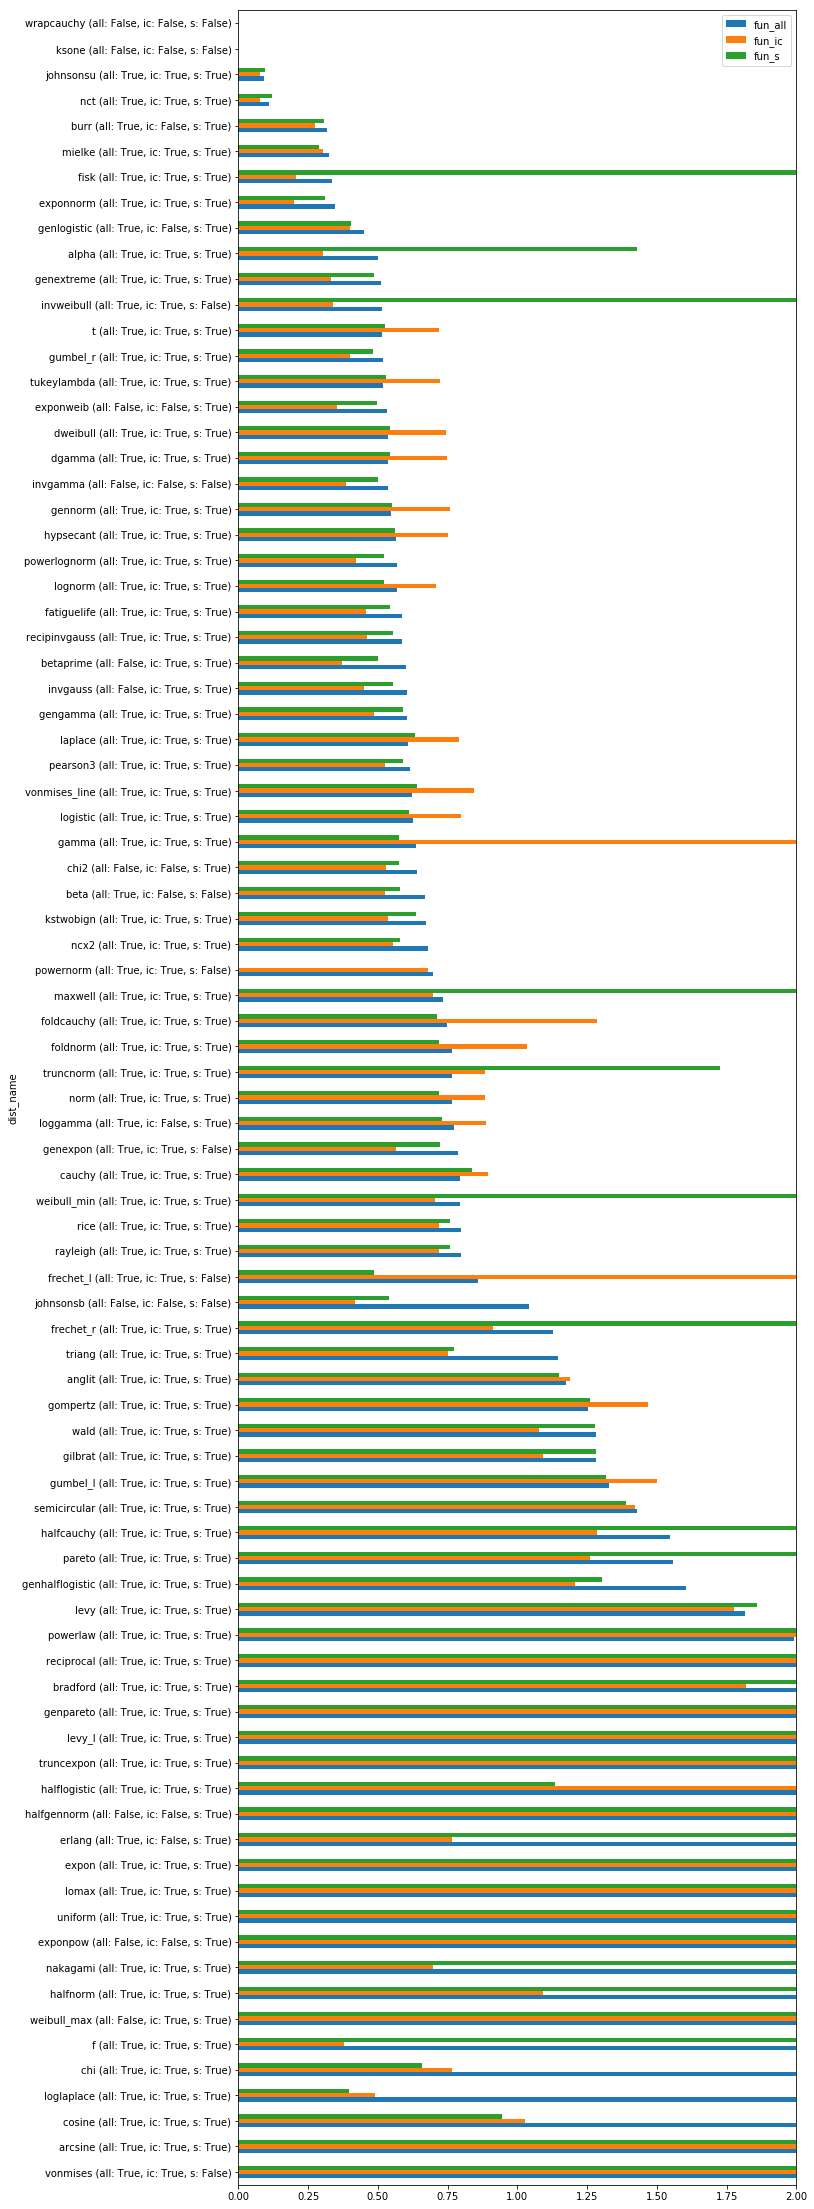

In [138]:
df_funs.plot(kind="barh", figsize=(10, 40), xlim=[0, 2])

In [26]:
def evaluate_arr_train_stop(train_id, bpuic, **kargs):
    data = df[(df["TRAIN_ID"] == train_id) & (df["BPUIC"] == bpuic)]["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
    print len(data)
    evaluate(data, **kargs)

230
alpha
anglit
arcsine
beta
betaprime
bradford
burr
cauchy
chi
chi2
cosine
dgamma
dweibull
erlang
expon
exponnorm
exponweib
exponpow
f
fatiguelife
fisk
foldcauchy
foldnorm
frechet_r
frechet_l
genlogistic
genpareto
gennorm
genexpon
genextreme
gamma
gengamma
genhalflogistic
gilbrat
gompertz
gumbel_r
gumbel_l
halfcauchy
halflogistic
halfnorm
halfgennorm
hypsecant
invgamma
invgauss
invweibull
johnsonsb
johnsonsu
ksone
kstwobign
laplace
levy
levy_l
logistic
loggamma
loglaplace
lognorm
lomax
maxwell
mielke
nakagami
ncx2
nct
norm
pareto
pearson3
powerlaw
powerlognorm
powernorm
reciprocal
rayleigh
rice
recipinvgauss
semicircular
t
triang
truncexpon
truncnorm
tukeylambda
uniform
vonmises
vonmises_line
wald
weibull_min
weibull_max
wrapcauchy


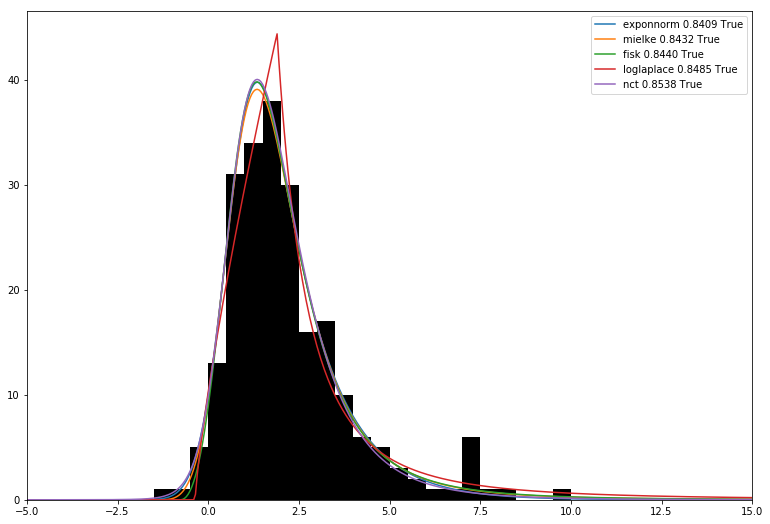

In [142]:
evaluate_arr_train_stop("85:11:1458", 8503000, step=0.5)

# Check for uniqueness

In [143]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB,TRAIN_ID
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT,80:807000:19700
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56,80:807000:19701
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT,80:807000:19702
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35,80:807000:19703
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT,80:807000:19704


In [148]:
df_count_per_day_train_id_bpuic = df[["BETRIEBSTAG", "TRAIN_ID", "BPUIC", "ABFAHRTSZEIT"]].groupby(["BETRIEBSTAG", "TRAIN_ID", "BPUIC"]).count()

In [149]:
print len(df_count_per_day_train_id_bpuic)

28439074


In [150]:
df_hmmm = df_count_per_day_train_id_bpuic[df_count_per_day_train_id_bpuic["ABFAHRTSZEIT"] > 1]

In [151]:
len(df_hmmm)

56

In [152]:
df_hmmm

ABFAHRTSZEIT
BETRIEBSTAG TRAIN_ID    BPUIC                
2018-09-29  85:22:1072  8506271             2
                        8506280             2
                        8506281             2
                        8506282             2
                        8506283             2
                        8506285             2
                        8506290             2
            85:22:1073  8506210             2
                        8506280             2
                        8506281             2
                        8506282             2
                        8506283             2
                        8506284             2
                        8506290             2
2018-10-19  85:81:9461  8500272             2
                        8500273             2
                        8500274             2
                        8500275             2
                        8500280             2
                        8500283             2
                        8500285             2
                        8500286             2
            85:81:9462  8500207             2
                        8500211             2
                        8500272             2
                        8500273             2
                        8500274             2
                        8500275             2
                        8500280             2
                        8500283             2
                        8500285             2
                        8500286             2
                        8500287             2
                        8500288             2
                        8500289             2
                        8518690             2
            85:81:9463  8500211             2
                        8500212             2
                        8500272             2
                        8500273             2
                        8500274             2
                        8500275             2
                        8500280             2
                        8500283             2
                        8500285             2
                        8500286             2
                        8500287             2
                        8500288             2
                        8500289             2
                        8518690             2
            85:81:9464  8500207             2
                        8500272             2
                        8500273             2
                        8500280             2
2018-10-21  85:11:10227 8501117             2
2018-12-14  85:65:11721 8506121             2

In [157]:
df[(df["BETRIEBSTAG"] == "2018-10-21") & (df["TRAIN_ID"] == "85:11:10227") & (df["BPUIC"] == 8501117)]

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB,TRAIN_ID
19721151,2018-10-21,85:11:10227:001,85:11,NZ,8501117,2018-10-22 00:13:00,2018-10-22 00:13:53,2018-10-22 00:15:00,NaT,00:00:53,NaT,85:11:10227
19721153,2018-10-21,85:11:10227:001,85:11,NZ,8501117,2018-10-22 00:27:00,NaT,2018-10-22 00:27:00,2018-10-22 00:48:04,NaT,00:21:04,85:11:10227
